# Análise de interpretabilidade para o modelo NGBoost

Este notebook analisará a interpretabilidade do melhor modelo treinado com o algoritmo *NGBoost*.

**Autor**: Edélio Gabriel Magalhães de Jesus.

<a id='sumario'></a>
## Sumário

<a id='interp'></a>
## 1. Interpretabilidade via SHAP

<a id='oqeshap'></a>
### 1.1 O que é o *SHAP*?

![image](https://shap.readthedocs.io/en/latest/_images/shap_header.png)

**Fonte:** [SHAP](https://shap.readthedocs.io/en/latest/)

O *SHAP (SHapley Additive exPlanations)* é uma abordagem baseada em teoria dos jogos para explicar a saída de qualquer modelo de aprendizado de máquina (“black-box”). 

O conceito central deriva dos valores de `Lloyd Shapley (Shapley values)`, originalmente desenvolvidos em jogos cooperativos, para distribuir “créditos” aos jogadores conforme suas contribuições marginais.

No contexto de modelos de ML, cada “jogador” é um *feature* (variável) ou valor de feature, e o “prêmio” do jogo é o valor de predição do modelo menos um valor de referência (por exemplo, a média da predição). 

<a id='inter_model'></a>
### 1.2 Relação com a interpretabilidade de modelos

Em muitos cenários de aprendizado de máquina, especialmente em modelos de alta complexidade (como ensembles, redes neurais…), temos alta acurácia mas baixa transparência (“caixa-preta”). SHAP ajuda a reduzir essa lacuna ao oferecer explicações compreensíveis para as previsões. Permite responder perguntas como: *Quais features mais contribuíram para esta previsão?* ou *Para um dado cliente, quais variáveis “empurraram” a predição para cima ou para baixo?*

Pode também ajudar na visão global do modelo: agregando valores SHAP sobre muitas instâncias, conseguimos visualizar quais features têm geralmente mais impacto nas previsões, detectar dependências ou interações, e até investigar vieses ou decisões inesperadas.

**Como funciona em termos gerais**  
1. Para uma dada instância de entrada $x$, o modelo prediz $f(x)$.  
2. A ideia é computar quanto cada feature contribui para essa predição, comparada à previsão média $\mathbb{E}[f(X)]$.  
3. Para cada feature $j$, consideram-se todas (ou muitas) as combinações possíveis de features que a precedem (coalitions). Para cada coalizão $S \subseteq \{1, \dots, p\} \setminus \{j\}$, mede-se a “valoração” $v(S \cup \{j\}) - v(S)$ — ou seja, a diferença de predição se incluirmos $j$ ou não. A média desta diferença (ponderada apropriadamente) dá o valor SHAP $\phi_j$.  
4. As contribuições $\phi_j$ de todas as features somam-se exatamente à diferença $f(x) - \mathbb{E}[f(X)]$. Essa é a propriedade de **eficiência**.  

**Propriedades importantes que tornam SHAP útil para interpretabilidade**  

- **Localidade**: SHAP explica *uma predição individual* (instância $x$), o que é muito relevante quando queremos entender “por que esse cliente foi aceito ou recusado?”.
  
- **Aditividade / Eficiência**: A soma das contribuições das features corresponde à diferença entre a predição e o valor médio, garantindo que nenhuma “parte” da explicação se perca.   
  
- **Consistência**: Em teoria, se o modelo altera-se de modo que a contribuição de um feature aumente, então seu valor SHAP não diminui — isso faz com que a explicação seja “justa” em termos de atribuição.  
  
- **Modelo-agnóstico (até certo ponto)**: SHAP pode ser aplicado a muitos tipos de modelos (regressão, árvores de decisão, redes neurais…) porque trata das features como “jogadores” sem depender fortemente da estrutura do modelo. 

<a id='usando'></a>
## 2. Usando o SHAP

<a id='modulo'></a>
### 2.1 Módulos necessários

Antes de tudo, certifique-se de ter instalado o módulo `shap`.

---

````python
pip install shap
````
---

In [5]:
import shap
# Leitura dos dados
import pandas as pd
import numpy as np

# Aprendizado de m�quina
from ngboost import NGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

# Otimiza��o de hiperpar�metros
from optuna import create_study, TrialPruned
from optuna.pruners import MedianPruner

import pickle
import shap
import pandas as pd

In [ ]:
<a id=''

<a id='avaliacao'></a>
### 2.2 Avaliando o melhor modelo

Para analisar a interpretabilidade do modelo vencedor encontrado pelo *Optuna*, precisamos carregá-lo a partir do arquivo de estudo utilizando a função `load_study`.

**Observação importante:** O *SHAP* não aceita um pipeline completo como entrada, ele requer um modelo final ou uma função de predição. Por isso, criamos um *trial* “falso” (`FixedTrial`) com os melhores hiperparâmetros para instanciar o pipeline vencedor.

Além disso, o modelo não é definido apenas pelos hiperparâmetros do algoritmo (`ElasticNet`), mas também inclui todas as etapas de pré-processamento do pipeline, como `StandardScaler`, `RFE`, `PCA` ou `VarianceThreshold`. Essas transformações devem ser aplicadas corretamente antes de calcular os valores de SHAP, garantindo que a explicação reflita exatamente como o modelo processa os dados.


In [8]:
from sklearn.pipeline import Pipeline

In [39]:
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0):
        self.threshold = threshold
        self.features_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)  # só para pegar nomes
        features = X.columns.tolist()
        X_work = X.copy()
        dropped = True
        while dropped:
            dropped = False
            vif = [variance_inflation_factor(X_work.values, i) for i in range(X_work.shape[1])]
            max_vif = max(vif)
            if max_vif > self.threshold:
                maxloc = vif.index(max_vif)
                X_work = X_work.drop(X_work.columns[maxloc], axis=1)
                dropped = True
        self.features_ = X_work.columns.tolist()
        return self

    def transform(self, X):
        # retorna array NumPy compatível com scikit-learn
        X = pd.DataFrame(X)
        return X[self.features_].values


In [21]:
df = pd.read_csv('../../dataset_processing/xtb_dataset.csv')

SEED = 88 # Semente aleat�ria

# =================
# LEITURA DOS DADOS
# =================
PERCENTAGE = 1.0
subset_df = df.sample(frac=PERCENTAGE, random_state=SEED)
X = subset_df.iloc[:, :-1]  # Features
y = subset_df.iloc[:, -1]   # Target

# Divis�o em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)


In [26]:
base_learner = DecisionTreeRegressor(
    max_depth=8,
    min_samples_split=8,
    min_samples_leaf=9,
    random_state=88
)
pipe = Pipeline(steps=[
    ('var', VarianceThreshold(threshold=0.0)),
    ('vif', VIFSelector(threshold=10.0)),
    ('scale', StandardScaler()),
    ('selector', RFE(LinearRegression(),n_features_to_select=8)),
    ('regressor', NGBRegressor(
        n_estimators=8,
        learning_rate=0.03129684669118429,
        minibatch_frac=0.8048065146892247,
        col_sample=0.9324907881783285
    ))
])

pipe.fit(X_train, y_train)

c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\edelio25024\OneDrive - ILUM ESCOLA DE CIÊNCIA\VSCODE\R2D2_MACHINE_LEARNING\R2D2\.venv\Lib\site-packages\sklearn\feature_selection\_rfe.py:300: UserWarning: Found n_features_to_select=8 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(


[iter 0] loss=2.1821 val_loss=0.0000 scale=1.0000 norm=1.7799


,steps,"[('var', ...), ('vif', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,threshold,0.0
,threshold,10.0
,copy,True
,with_mean,True
,with_std,True
,estimator,LinearRegression()
,n_features_to_select,8


ExactExplainer explainer: 25833it [05:10, 80.23it/s]                           


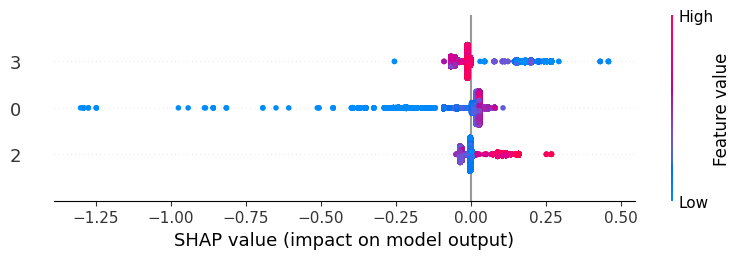

In [47]:
import pandas as pd
import shap
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor

# -------------------------
# 1️⃣ Adaptando VIFSelector para funcionar com arrays
# -------------------------
class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0):
        self.threshold = threshold
        self.features_ = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        X_work = X.copy()
        dropped = True
        while dropped:
            dropped = False
            vif = [variance_inflation_factor(X_work.values, i) for i in range(X_work.shape[1])]
            max_vif = max(vif)
            if max_vif > self.threshold:
                maxloc = vif.index(max_vif)
                X_work = X_work.drop(X_work.columns[maxloc], axis=1)
                dropped = True
        self.features_ = X_work.columns.tolist()
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        # retorna apenas valores, DataFrame reconstruído depois
        return X[self.features_].values

# -------------------------
# 2️⃣ Extrair passos da pipeline existente
# -------------------------
var_selector = pipe.named_steps['var']
vif_selector = pipe.named_steps['vif']
scaler = pipe.named_steps['scale']
rfe_selector = pipe.named_steps['selector']
final_model = pipe.named_steps['regressor']

# -------------------------
# 3️⃣ Transformar X_train passo a passo
# -------------------------
X_var = pd.DataFrame(
    var_selector.transform(X_train),
    columns=X_train.columns[var_selector.get_support()]
)

X_vif_array = vif_selector.transform(X_var.values)
X_vif = pd.DataFrame(X_vif_array, columns=vif_selector.features_)

X_scaled_array = scaler.transform(X_vif.values)
X_scaled = pd.DataFrame(X_scaled_array, columns=X_vif.columns)

selected_cols = X_vif.columns[rfe_selector.get_support()]
X_train_transformed_df = pd.DataFrame(
    rfe_selector.transform(X_scaled.values),
    columns=selected_cols
)

# -------------------------
# 4️⃣ Transformar X_test do mesmo jeito
# -------------------------
X_test_var = pd.DataFrame(
    var_selector.transform(X_test),
    columns=X_train.columns[var_selector.get_support()]
)

X_test_vif_array = vif_selector.transform(X_test_var.values)
X_test_vif = pd.DataFrame(X_test_vif_array, columns=vif_selector.features_)

X_test_scaled_array = scaler.transform(X_test_vif.values)
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=X_test_vif.columns)

X_test_transformed_df = pd.DataFrame(
    rfe_selector.transform(X_test_scaled.values),
    columns=selected_cols
)

# -------------------------
# 5️⃣ Wrapper para NGBoost
# -------------------------
def ngb_predict(X):
    return final_model.predict(X)  # retorna a média da previsão

# -------------------------
# 6️⃣ Subamostragem do background (opcional para acelerar)
# -------------------------

# -------------------------
# 7️⃣ Criar explainer SHAP
# -------------------------
explainer = shap.Explainer(ngb_predict, X_train_transformed_df, feature_names=selected_cols.tolist())
shap_values = explainer(X_test_transformed_df)
# -------------------------
# 8️⃣ Visualização SHAP
# -------------------------
shap.summary_plot(shap_values)

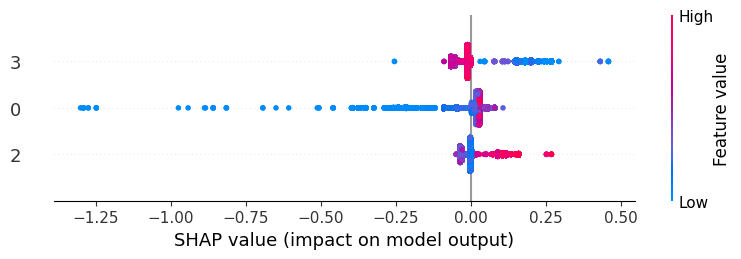

In [46]:
shap.summary_plot(shap_values.values, features=X_test_transformed_df, feature_names=selected_cols.tolist())


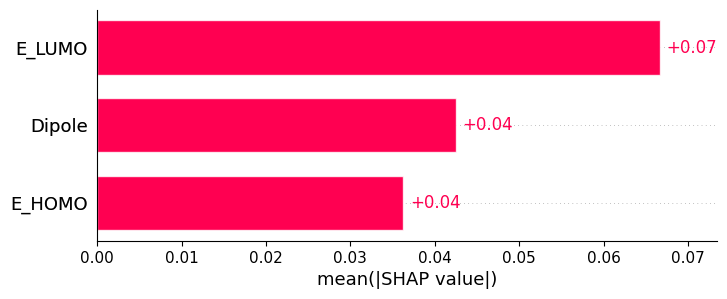

In [43]:

# shap_values já é um numpy.ndarray
shap_values_exp = shap.Explanation(
    values=shap_values,        # passa o array direto
    data=X_test,               # seu DataFrame de teste
    feature_names=X_test.columns
)

shap.plots.bar(shap_values_exp)

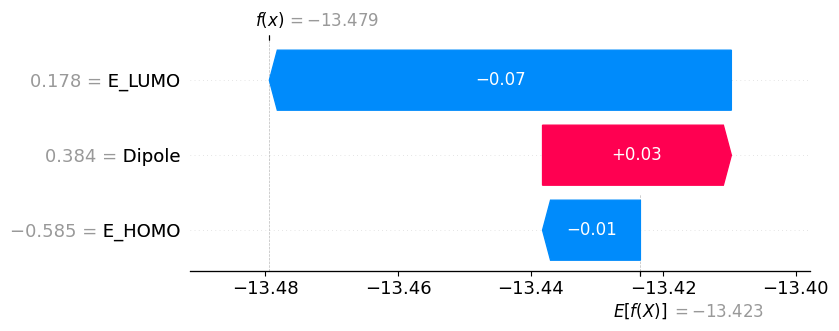

In [44]:
shap.plots.waterfall(shap_values_exp[1])
